## Week 4 Individual Assignment: Exploring Oil Spill Data in LA County

Jeremy Epstein

My team is going to map oil spills in LA county as part of our final project.  We are using data from US DOT's website (see <a href="https://www.phmsa.doset Hazardous Liquid Accident Data - January 2010 to presentt.gov/dataand-statistics/pipeline/distribution-transmission-gathering-lng-and-liquid-accident-and-incident-data">here</a>, the set *Hazardous Liquid Accident Data - January 2010 to present*)

This is a national data set.  I started by culling it down to spills that happened in LA county in Excel.

There are also a million columns in this dataset, many of which are empty.  For the purposes of this exercise, I threw away everything not related to location, cost, and damages.

In [1]:
# Let's bring in some libraries

import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [2]:
# And the data

spills = pd.read_csv('LA_spills.csv')

In [7]:
# Exploring the data...

type(spills)

pandas.core.frame.DataFrame

In [8]:
spills.head()

,IYEAR,LOCATION_LATITUDE,LOCATION_LONGITUDE,UNINTENTIONAL_RELEASE_BBLS,RECOVERED_BBLS,EST_COST_OPER_PAID,EST_COST_GAS_RELEASED,EST_COST_PROP_DAMAGE,EST_COST_EMERGENCY,EST_COST_ENVIRONMENTAL,EST_COST_OTHER,TOTAL_DAMAGE_COSTS,COSTPAID_ofTOTAL
0,2013,33.949629,-118.370221,10.00,5.00,0,1000,96278,2861558,130033,18256,3106125,0.00%
1,2017,33.757825,-118.111294,100.00,100.00,0,6273,54752,75822,0,0,130574,0.00%
2,2016,33.758661,-118.203322,2.98,2.98,0,120,7000,3000,0,0,10000,0.00%
3,2016,33.764961,-118.209047,0.50,0.50,0,15,1000,3000,0,0,4000,0.00%
4,2015,33.804707,-118.222597,264.00,56.00,0,27720,0,0,267152,0,267152,0.00%


In [9]:
# NB: I created the final two columns, the total by summing the preceding 4 columns and the percentage column by dividing the amount paid

In [12]:
spills.tail()

,IYEAR,LOCATION_LATITUDE,LOCATION_LONGITUDE,UNINTENTIONAL_RELEASE_BBLS,RECOVERED_BBLS,EST_COST_OPER_PAID,EST_COST_GAS_RELEASED,EST_COST_PROP_DAMAGE,EST_COST_EMERGENCY,EST_COST_ENVIRONMENTAL,EST_COST_OTHER,TOTAL_DAMAGE_COSTS,COSTPAID_ofTOTAL
13,2021,34.005640,-118.370500,18.00,18.00,0,140,0,6500,0,0,6500,0.00%
14,2019,33.804527,-118.221099,1.00,1.00,0,0,95500,30000,10000,0,135500,0.00%
15,2014,34.057767,-118.360143,0.12,0.00,500,25,150000,20000,0,15000,185000,0.27%
16,2011,34.052234,-118.243685,0.50,0.50,0,50,0,12000,0,61000,73000,0.00%
17,2011,33.756403,-118.205749,0.48,0.48,0,0,26000,0,0,0,26000,0.00%


In [16]:
spills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IYEAR                       18 non-null     int64  
 1   LOCATION_LATITUDE           18 non-null     float64
 2   LOCATION_LONGITUDE          18 non-null     float64
 3   UNINTENTIONAL_RELEASE_BBLS  18 non-null     float64
 4   RECOVERED_BBLS              18 non-null     float64
 5   EST_COST_OPER_PAID          18 non-null     int64  
 6   EST_COST_GAS_RELEASED       18 non-null     int64  
 7   EST_COST_PROP_DAMAGE        18 non-null     int64  
 8   EST_COST_EMERGENCY          18 non-null     int64  
 9   EST_COST_ENVIRONMENTAL      18 non-null     int64  
 10  EST_COST_OTHER              18 non-null     int64  
 11  TOTAL_DAMAGE_COSTS          18 non-null     int64  
 12  COSTPAID_ofTOTAL            18 non-null     object 
dtypes: float64(4), int64(8), object(1)
me

In [17]:
# The lat/long coordinates are float64, which should help us map the spills.

# The costpaid column at the end which I added to the Excel file came out as an object, probably because it was a percentage.

Let's do some preliminary analysis. I'm curious how the spills stack up in terms of quantity.

In [18]:
spills['UNINTENTIONAL_RELEASE_BBLS'].describe()

count     18.000000
mean      78.843333
std      235.982689
min        0.120000
25%        0.700000
50%        1.990000
75%       13.750000
max      989.000000
Name: UNINTENTIONAL_RELEASE_BBLS, dtype: float64

In [21]:
# So out of 18 spills, the mean amount released was about 79 barrels

# That said, there is a lot of range.  The standard deviation is nearly 3x the mean!

# It appears the majority of the 18 spills were quite small, but there are a couple HUGE outliers on the larger end.

# What are the implications for making scaled spill markers? Will it work out if we have some tiny spill dots and a couple huge ones? Hmmm..

<AxesSubplot:ylabel='Frequency'>

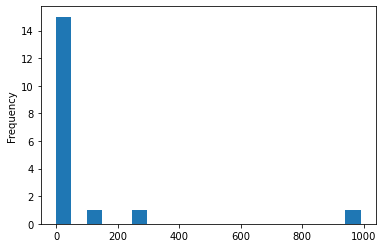

In [34]:
spills['UNINTENTIONAL_RELEASE_BBLS'].plot.hist(bins=20)

In [27]:
# Hmmmmmmm

# Maybe the cost variance is greater?

<AxesSubplot:ylabel='Frequency'>

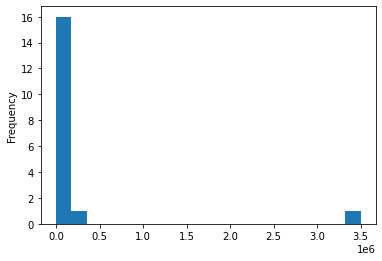

In [35]:
spills['EST_COST_ENVIRONMENTAL'].plot.hist(bins=20)

In [30]:
# Well, in hindsight that correlation perhaps shouldn't come as a surprise...

Ok lets make a map.

In [39]:
# Let's first trim down the set...

spills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IYEAR                       18 non-null     int64  
 1   LOCATION_LATITUDE           18 non-null     float64
 2   LOCATION_LONGITUDE          18 non-null     float64
 3   UNINTENTIONAL_RELEASE_BBLS  18 non-null     float64
 4   RECOVERED_BBLS              18 non-null     float64
 5   EST_COST_OPER_PAID          18 non-null     int64  
 6   EST_COST_GAS_RELEASED       18 non-null     int64  
 7   EST_COST_PROP_DAMAGE        18 non-null     int64  
 8   EST_COST_EMERGENCY          18 non-null     int64  
 9   EST_COST_ENVIRONMENTAL      18 non-null     int64  
 10  EST_COST_OTHER              18 non-null     int64  
 11  TOTAL_DAMAGE_COSTS          18 non-null     int64  
 12  COSTPAID_ofTOTAL            18 non-null     object 
dtypes: float64(4), int64(8), object(1)
me

In [43]:
# I'll define the dataset I'm going to map as sp for ease of use

sp=spills[['LOCATION_LATITUDE','LOCATION_LONGITUDE','UNINTENTIONAL_RELEASE_BBLS','EST_COST_PROP_DAMAGE']]
sp

,LOCATION_LATITUDE,LOCATION_LONGITUDE,UNINTENTIONAL_RELEASE_BBLS,EST_COST_PROP_DAMAGE
0,33.949629,-118.370221,10.00,96278
1,33.757825,-118.111294,100.00,54752
2,33.758661,-118.203322,2.98,7000
3,33.764961,-118.209047,0.50,1000
4,33.804707,-118.222597,264.00,0
5,33.806106,-118.158872,5.00,50000
6,33.806917,-118.227056,989.00,0
7,34.044058,-118.441362,15.00,175000
8,34.005510,-118.144770,0.60,8000
9,33.846624,-118.252704,1.00,160000


In [50]:
# and changet the names...

sp.columns.to_list()

sp.columns = ['LAT','LONG','RELEASE','COST']

sp

,LAT,LONG,RELEASE,COST
0,33.949629,-118.370221,10.00,96278
1,33.757825,-118.111294,100.00,54752
2,33.758661,-118.203322,2.98,7000
3,33.764961,-118.209047,0.50,1000
4,33.804707,-118.222597,264.00,0
5,33.806106,-118.158872,5.00,50000
6,33.806917,-118.227056,989.00,0
7,34.044058,-118.441362,15.00,175000
8,34.005510,-118.144770,0.60,8000
9,33.846624,-118.252704,1.00,160000


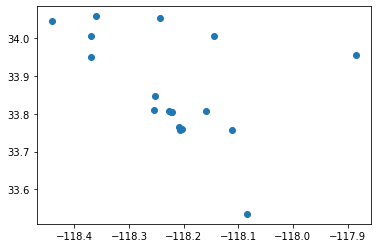

In [52]:
plt.scatter(x=sp['LONG'], y=sp['LAT'])

In [60]:
# That looks kind of like a basic map! Can we get it on a basemap?

# Edit: Not at the moment.. Going to have to return to this to get it on a map and learn to scale the points next time.